In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Order:

#     init network params
#     init graph
#     visualize it
#     determine moving nodes
#     determine where and which packets to send
#     loop wrt time till either transmittion is over or cannot take place

# Network Params

In [3]:
UNIT_DISTANCE = 1000 # 1 KM
IDLE_ENERGY = 0.1 #joule per second
BANDWIDTH = 2000 #Bytes per second
k = 1
MAX_DISTANCE = 5

INITIAL_ENERGY = 10

ALPHA = 0.7
BETA = 0.3
RHO = 0.1


TRANSMISION_COST = 0.0001 #PER SEOCIND
RECEIVING_COST = 0.001 #PER SEOCIND

FORWARD_ANT_SIZE = 10000 # ant + Packet
BACKWARD_ANT_SIZE = 1000 # ant + ACK


INITIAL_PHEROMONE = 1

In [4]:
# ENERGY = k/d^2

In [5]:
def dist(node1 , node2):
    return np.sqrt((node1.x - node2.x)**2 + (node1.y - node2.y)**2)


In [6]:
class Node:
    def __init__(self,pos ,n, energy = INITIAL_ENERGY , vel = (0,0)):
        self.energy = energy - 3
        self.INITIAL_ENERGY = energy
        self.x = pos[0]
        self.y = pos[1]
        self.n = n
        self.vel = vel
        self.routing_table = []
        self.pheromone = np.ones(n) * INITIAL_PHEROMONE
    def __eq__(self,other):
        if (self.x,self.y) == (other.x , other.y):
            return True
        else:
            return False
    
    def transmit_ant(self,node,ANT_SIZE = FORWARD_ANT_SIZE):
        self.energy -= 0.01*((dist(self,node)/MAX_DISTANCE)**2) + (ANT_SIZE/BANDWIDTH)*TRANSMISION_COST
    def receive_ant(self,node , ANT_SIZE = FORWARD_ANT_SIZE):
        self.energy -= (ANT_SIZE/BANDWIDTH)*RECEIVING_COST
    def add_pheromone(self,node,trail):
        self.pheromone[node] += trail
    def update_pheromone(self):
        self.pheromone*= (1-RHO)
    def update(self):
        self.x += self.vel[0]*0.1
        self.y += self.vel[1]*0.1        
        self.energy -= IDLE_ENERGY
        if self.energy < 0:
            self.energy = -99
        

In [7]:
class Graph:
    def __init__(self,nodes):
        self.n = len(nodes)
        self.nodes = [Node(pos,self.n) for pos in nodes]
        
        
    def draw(self):
        plt.clf()
        count = 0
        for node in self.nodes:
            if node.energy > 0:
                plt.plot(node.x, node.y, 'o', markersize= 10, markeredgecolor = [0,1,0], markerfacecolor = [0.5,1,0.5])
                plt.annotate(count, (node.x,node.y))
            else:
                plt.plot(node.x, node.y, 'o', markersize= 10, markeredgecolor = [1,0,0], markerfacecolor = [1,0.5,0.5])
                plt.annotate(count, (node.x,node.y))
            count+=1
        for i , node1 in enumerate(self.nodes):
            for j , node2 in enumerate(self.nodes):
                if (dist(self.nodes[i] , self.nodes[j]) < MAX_DISTANCE) and (node1.energy > 0) and (node2.energy > 0):
                    x = [self.nodes[i].x,self.nodes[j].x]
                    y = [self.nodes[i].y,self.nodes[j].y]
                    plt.plot(x,y,c = [0.5,1,0.5])
                    
        plt.pause(0.1)
    def find_neighbors(self,node):
        edges = []
        for node2 in self.nodes:
            if (node != node2) and (dis := dist(node,node2) < MAX_DISTANCE) and (node2.energy > 0) and (node.energy > 0):
                edges.append(dis)
            else:
                edges.append(0)
        return np.array(edges , dtype = float)
    def update(self):
        for node in self.nodes:
            node.update_pheromone()
            node.update()

In [8]:
class Ant:
    def __init__(self , graph , initial_node , sink ):
        self.graph = graph
        self.distance_travelled = 0
        self.initial_node = initial_node
        self.sink = sink
        self.path = [initial_node]
        self.visited = np.zeros(graph.n)
        self.visited[initial_node] = 1
        self.current_node = initial_node
        self.avg_energy = 0
        self.min = np.inf
    def select_node(self):
        prob = np.zeros(self.graph.n)
        for i in range(self.graph.n):
            if self.visited[i] == 0 and self.graph.find_neighbors(graph.nodes[self.current_node])[i] != 0:
                node = self.graph.nodes[i]
                
                visibility = 1/(node.INITIAL_ENERGY - node.energy)
                pheromone = node.pheromone[i]
                
                prob[i] = (pheromone**ALPHA)*(visibility**BETA)
        if np.sum(prob) == 0:
            return False
        prob = prob/np.sum(prob)
        return np.random.choice(self.graph.n,p = prob)
    
    def forward_walk(self):
        if self.graph.nodes[self.current_node].energy < 0:
            return "DEAD"
        while (node := self.select_node()):
            self.visited[node] = 1
            self.path.append(node)
            
            self.graph.nodes[self.current_node].transmit_ant(self.graph.nodes[node] , ANT_SIZE = FORWARD_ANT_SIZE)
            self.graph.nodes[node].receive_ant(self.current_node , ANT_SIZE = FORWARD_ANT_SIZE)
            
            self.avg_energy =  ((self.avg_energy*(sum(self.visited) - 1))  + self.graph.nodes[node].energy) / sum(self.visited)
            self.min = min(self.graph.nodes[node].energy , self.min)
            
            
            
            
            
            
            self.distance_travelled += dist(self.graph.nodes[self.current_node] , self.graph.nodes[node])
            
            self.current_node = node
            
            if self.current_node == self.sink:
                # ANT REACHED THE SINK
                self.backward_walk()
                return True
        # ANT CANNOT REACH THE SINK
        return False
    def backward_walk(self):
        
        trail =  1/(INITIAL_ENERGY - ((self.min - len(self.path))/(self.avg_energy - len(self.path))))*self.distance_travelled
        rev_path = self.path[:-1]
        rev_path = self.path[::-1]
        for node in rev_path:
            self.graph.nodes[self.current_node].add_pheromone(node , trail)
            self.graph.nodes[node].add_pheromone(self.current_node , trail) 
#             self.graph.nodes[self.current_node].transmit_ant(self.graph.nodes[node] , ANT_SIZE = BACKWARD_ANT_SIZE)
#             self.graph.nodes[node].receive_ant(self.current_node , ANT_SIZE = BACKWARD_ANT_SIZE)
            self.current_node = node
    
    def draw(self,graph):
        current = self.path[0]
        for node in self.path[1:]:
            x = [graph.nodes[current].x,graph.nodes[node].x]
            y = [graph.nodes[current].y,graph.nodes[node].y]
            plt.plot(x,y,c = [0.5,0.5,1])
            current = node
        plt.pause(0.1)

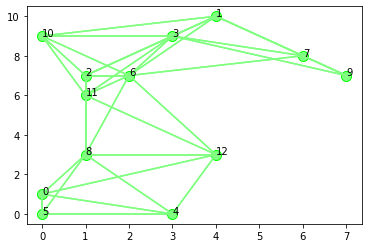

In [23]:
graph = Graph([(0,1),(4,10),(1,7),(3,9),(3,0),(0,0),(2,7),(6,8),(1,3),(7,7),(0,9),(1,6),(4,3)])
graph.nodes[2].vel = (0.5,-0.7)
graph.draw()
graph.nodes[7].vel = (0.5,0.01)
graph.nodes[11].vel = (-0.1,0.3)
graph.nodes[1].vel = (-0.5,0.3)
graph.nodes[0].vel = (0.6,-0.5)
# graph.draw()

[2, 1, 3, 11, 10, 6, 12, 4]
[1, 7, 3, 10, 11]
[7, 3, 1, 9]
[2, 6, 1, 3, 10, 11, 12, 4]
[1, 11]
[7, 3, 10, 11, 6, 12, 2, 1, 9]
[2, 12, 4]
[1, 3, 11]
[7, 9]
[2, 1, 11, 10, 3, 9, 7, 6, 12, 4]
[1, 11]
[7, 3, 10, 2, 1, 9]
[2, 1, 6, 3, 10, 11, 12, 4]
[1, 3, 9, 7, 6, 11]
[7, 6, 11, 1, 9]
[2, 1, 9, 3, 11, 10, 6, 12, 4]
[1, 9, 3, 10, 11]
[7, 6, 11, 1, 9]
[2, 1, 9, 3, 6, 11, 12, 4]
[1, 10, 3, 11]
[7, 3, 2, 12, 4, 8, 6, 1, 9]
[2, 1, 6, 7, 9, 3, 10, 11, 12, 4]
[1, 11]
[7, 6, 11, 3, 9]
[2, 10, 6, 7, 9, 1, 3, 11, 12, 4]
[1, 11]
[7, 9]
[2, 3, 10, 11, 12, 4]
[1, 10, 3, 9, 7, 6, 11]
[7, 9]
[2, 12, 4]
[1, 11]
[7, 9]
[2, 1, 9, 7, 6, 11, 12, 4]
[1, 11]
[7, 3, 9]
[2, 12, 4]
[1, 2, 10, 11]
[7, 9]
[2, 10, 11, 6, 12, 4]
[1, 11]
[7, 9]
[2, 1, 6, 11, 12, 4]
[1, 2, 10, 11]
[7, 6, 1, 2, 10, 3, 9]
[2, 10, 3, 11, 1, 7, 6, 8, 12, 4]
[1, 11]
[7, 1, 2, 3, 9]
[2, 10, 3, 9, 7, 1, 6, 8, 11, 12, 4]
[1, 2, 10, 6, 11]
[7, 6, 11, 1, 2, 10, 3, 9]
[2, 1, 7, 9, 3, 6, 10, 11, 8, 4]
[1, 6, 7, 9, 3, 10, 2, 8, 11]
[7, 1, 11, 6, 3, 

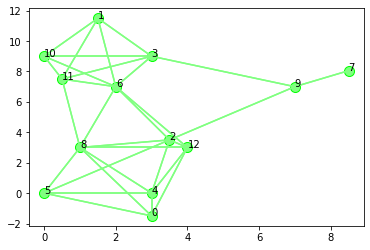

[[5.15377521e-03 5.15377521e-03 5.15377521e-03 5.15377521e-03
  5.15377521e-03 5.15377521e-03 5.15377521e-03 5.15377521e-03
  5.15377521e-03 5.15377521e-03 5.15377521e-03 5.15377521e-03
  5.15377521e-03]
 [5.15377521e-03 5.15377521e-03 1.17662352e+00 3.94818050e+00
  5.15377521e-03 5.15377521e-03 1.42188230e+01 1.02515442e+00
  5.15377521e-03 4.17795899e-01 3.60500079e+00 4.84168669e+00
  5.15377521e-03]
 [5.15377521e-03 1.17662352e+00 5.15377521e-03 6.77056932e+00
  5.08926777e-01 5.15377521e-03 6.44036661e+00 5.15377521e-03
  5.76333745e+00 3.74264614e+00 2.76099412e+00 5.15377521e-03
  1.92140545e-01]
 [5.15377521e-03 3.94818050e+00 6.77056932e+00 5.15377521e-03
  5.15377521e-03 5.15377521e-03 2.85904189e+00 4.20533270e-01
  5.15377521e-03 4.74012839e+00 1.00941401e+01 8.70659545e+00
  5.15377521e-03]
 [5.15377521e-03 5.15377521e-03 5.08926777e-01 5.15377521e-03
  3.28973421e+01 4.90517537e+00 5.15377521e-03 5.15377521e-03
  6.56557748e+00 5.15377521e-03 5.15377521e-03 5.15377521e-0

In [24]:
no_of_packets = 50
running = True
total = 0
failed_attempts = 0
paths = [(graph,2,4),(graph,1,11),(graph,7,9)]
while no_of_packets > 0 and running:
    
    for i,path in enumerate(paths):
        ant = Ant(path[0],path[1],path[2])
        total += failed_attempts
        failed_attempts = 0
        while not (result:=ant.forward_walk()): 
            failed_attempts += 1
            ant = Ant(path[0],path[1],path[2])
            if failed_attempts > 300:
                print("PATH BREAK")
                paths.pop(i)
                break
        if result == "DEAD":
            print("SOURCE NODES DIED")
            paths.pop(i)
            break
#         ant.draw(graph)
        print(ant.path)
    graph.update()
#     graph.draw()
    no_of_packets -= 1
print(total)
print(np.array([node.energy for node in graph.nodes]))
graph.draw()
print(np.array([node.pheromone for node in graph.nodes]))